In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from bs4 import BeautifulSoup
import random
import string
from collections import Counter
import jieba.posseg as pseg




# 数据来源：  
1.Wang, Y., Yang, W., Ma, F., Xu, J., Zhong, B., Deng, Q., & Gao, J. (2020). Weak Supervision for Fake News Detection via Reinforcement Learning. Proceedings of the AAAI Conference on Artificial Intelligence, 34(01), 516-523.

后面分析发现都是来自微信公众号平台

网页：

# 数据统计

In [2]:
"""文档读取csv文件"""
data = pd.read_csv('./train/train.csv')
data.head()

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
0,0,朝阳实拍,范冰冰出轨被偷拍？这才是真相！,http://mp.weixin.qq.com/s?__biz=MzI1NzIzNDkxNQ...,http://mmbiz.qpic.cn/mmbiz_jpg/XUUcJo9yhYRlbzt...,发布误导信息,1
1,1,文刊,马容竟然去了非诚匆扰，一出场24盏灯全灭，孟爷爷都笑了,http://mp.weixin.qq.com/s?__biz=MzUxODE2MDMwMQ...,https://mmbiz.qlogo.cn/mmbiz_jpg/X3Cv4sIxE7Bib...,标题与内容不符##骗点击##欺骗阅读者。,1
2,2,掌上武冈,突发：武冈西站木材市场燃起大火，浓烟滚滚火势巨大，现场...,http://mp.weixin.qq.com/s?__biz=MzAwMjM0NzMxOA...,https://mmbiz.qlogo.cn/mmbiz_jpg/fnLwjhfLVGZQK...,报道内容不实，描述事实也不食,0
3,3,时事内幕爆料,辞职交警!爆`出贪 污惊人内幕！99%车主都不知道！速看,http://mp.weixin.qq.com/s?__biz=MzU3NjIzNTI5OA...,https://mmbiz.qlogo.cn/mmbiz_jpg/hYnJtOcFjEhV0...,谣言！##不实,0
4,4,大参考,美国两块让国人汗颜的告示牌，告诉我们离文明有多远,http://mp.weixin.qq.com/s?__biz=MzA5MDE4NTY4Mw...,http://mmbiz.qpic.cn/mmbiz_jpg/T0OtTToYoIR77vL...,虚假宣传##以偏概全,0


In [3]:
"""数据信息"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     10587 non-null  int64 
 1   Ofiicial Account Name  10585 non-null  object
 2   Title                  10587 non-null  object
 3   News Url               10587 non-null  object
 4   Image Url              10587 non-null  object
 5   Report Content         10587 non-null  object
 6   label                  10587 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 579.1+ KB


In [4]:
"""读取单个html"""
# with open('./train/html/0.html', encoding='utf-8') as f:
#     html = f.read()
#     print(html)

'读取单个html'

In [5]:
"""真假新闻个数, 虚假新闻占比"""
data['label'].value_counts(), f"{data['label'].value_counts()[1]/data['label'].value_counts()[0]:.6f}"

(label
 0    7844
 1    2743
 Name: count, dtype: int64,
 '0.349694')

In [6]:
"""是否都是来自微信公众号"""
data.count(), data['News Url'].str.contains('mp.weixin.qq.com').value_counts()


(id                       10587
 Ofiicial Account Name    10585
 Title                    10587
 News Url                 10587
 Image Url                10587
 Report Content           10587
 label                    10587
 dtype: int64,
 News Url
 True    10587
 Name: count, dtype: int64)

# html分析

In [7]:
"""html文件读取"""

html_list = []
for i in tqdm(range(data.shape[0])):
    with open("./train/html/{}.html".format(i), encoding='utf-8') as f:
        html = f.read()
        html_list.append(html)
html_list = pd.Series(html_list)
html_list.head()

100%|██████████| 10587/10587 [00:12<00:00, 845.98it/s]


0    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
1    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
2    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
3    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
4    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
dtype: object

In [8]:
"""html文件长度"""
html_lengths = list(html_list.apply(lambda x: len(x)))
html_lengths_pd = pd.DataFrame(html_lengths, columns=['html_lenths'])
print("info:", html_lengths_pd.info())
print("describe:\n", html_lengths_pd.describe())
print("众数及其数量:\n", html_lengths_pd.mode())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   html_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
          html_lenths
count   10587.000000
mean   178249.129876
std    252367.988048
min     17690.000000
25%     27555.000000
50%     27876.000000
75%    572228.500000
max    944942.000000
众数及其数量:
    html_lenths
0        27555


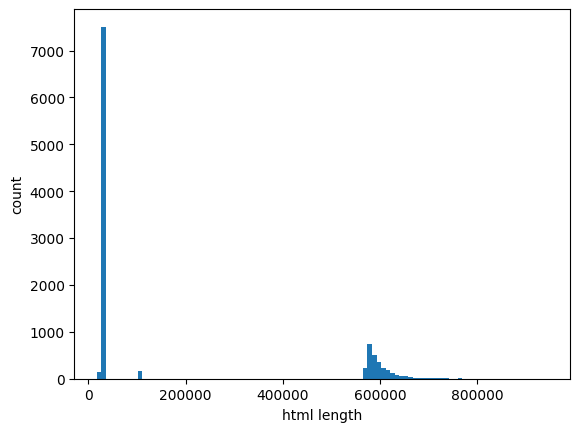

In [9]:
"""html文件长度分布图"""
plt.hist(html_lengths, bins=100)
plt.xlabel('html length')
plt.ylabel('count')
plt.show()


In [10]:
html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       10568, 10569, 10571, 10573, 10575, 10576, 10577, 10581, 10582, 10585],
      dtype='int64', length=7834)

In [11]:
"""筛选html文件长度小于200000的,并得到序号"""
shortlen_html_pd = pd.DataFrame(html_lengths_pd[html_lengths_pd['html_lenths'] < 200000],
                                index = html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index)
print(shortlen_html_pd.describe())
print(shortlen_html_pd.value_counts())

         html_lenths
count    7834.000000
mean    29196.990809
std     11133.430110
min     17690.000000
25%     27555.000000
50%     27555.000000
75%     28016.000000
max    102502.000000
html_lenths
27555          4054
27673           581
28016           471
28053           362
27251           352
               ... 
24312             1
28089             1
29679             1
29519             1
27340             1
Name: count, Length: 120, dtype: int64


# text分析

In [12]:
"""通过utf-8编码将html文件中的文字和汉字符号部分提取出来"""
number = [n for n in string.digits]
chinese_symbol = ['。', '，', '！', '？', '；', '：', '“', '”', '‘', '’', '（', '）', '《', '》', '、', '…', '—', '【', '】']
text_list = []
for html in tqdm(html_list):
    soup = BeautifulSoup(html)
    chinese_text = ''.join(soup.stripped_strings)
    chinese_text = [char for char in chinese_text if '\u4e00' <= char <= '\u9fff' or char in chinese_symbol or char in number]
    text_list.append(''.join(chinese_text))


100%|██████████| 10587/10587 [01:03<00:00, 167.06it/s]


In [13]:
"""浏览"""
def showText(text_list):
    for i in range(100):
        index = random.randint(0, len(text_list))
        print(index, '\t', text_list[index])
showText(text_list)

8533 	 该内容已被发布者删除微信公众平台运营中心：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
5806 	 此账号已被屏蔽内容无法查看接相关投诉，此账号涉嫌违反《互联网用户公众账号信息服务管理规定》，查看详细内容：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
10113 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，涉嫌违反相关法律法规和政策，查看对应规则我要申诉微信公众平台运营中心：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
4204 	 该内容已被发布者删除微信公众平台运营中心：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
3796 	 85咖啡店完蛋了网轰小英死亡之签成长中国在蔡英文到杉矶的晚上，台湾总统汽车队经过台企85度咖啡店。全体到该店品咖啡。有一个售货员拿了该店的吉祥物请蔡英文签名。这一举动被世界日报刊出后，立刻受到大陆网民的不满，认为该店是台独企业。否则为什么要请蔡英文签名？有些网民就要求拒到85度去大陆网民对该店请蔡英文签名提出怀疑是可以理解的。蔡英文过境洛杉矶，车队经过85度时，下车与随团立委点咖啡喝，店员赶紧拿出吉祥物抱枕给小英签名。（取自立委蔡适应脸书）对此85度大陆官网发出三点声明，指公司坚定支持九二共识及两岸一家亲信念，对于台湾当局领导人来访，是店员拿吉祥物给蔡签名，作私人留念，并非店家准备大礼包。这个申明也很不在理。店员怎么可以用店的吉祥物给蔡签名，作私人留念？至少说明这个点缺乏管理。我看是推脱之词。不过既然表态了坚定支持九二共识及两岸一家亲信念。大陆的网友也就算了。不再计较。不料台湾的民进党却不干了，纷纷起来批判85度，有的说丢了台湾的脸，有的说干脆你把台湾的店关了，不是你在大陆的店比台湾多吗？而且遗憾的是，在该公司力图澄清真相的过程，总统府却还刻意强调这次造访是事先规画而非临时起意，仿佛还要加深大陆网友的敌意。蔡政府若如此以激怒中共为乐，却丝毫不为企业设想；未来她再要拜会企业，难保不会遭业者以政治风险太高为由，拒于门外了。蔡政府更要深刻检讨，两岸的回旋敌意再这样下去，会导致多少企业遭殃，会有多少更具破坏性的案例发生？是的，85是台商上市公司，在开曼群岛注册，台湾有435家店，大陆有589家店，美国有44家店，澳大利亚、香港都有分

In [14]:
"""数据清洗，将无用的语句、信息删除"""

dirty_words = ["：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看",
               "分享留言收藏",
               "向上滑动看下一个知道了微信扫一扫使用小程序取消允许取消允许分析",
               "预览时标签不可点微信扫一扫关注该公众号继续滑动看下一个轻触阅读"
               ]
for index, test in enumerate(text_list):
    for dirty_word in dirty_words:
        text_list[index] = text_list[index].replace(dirty_word, '')
showText(text_list)


7476 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，涉嫌违反相关法律法规，查看对应规则我要申诉微信公众平台运营中心
9977 	 快讯！福建一家85度被查出……还有人曾在面包中吃出蚯蚓、黑虫、螺钉……海峡都市报85度官网显示，在福建有180家门店其中在福州42家，厦门20家不少年轻人都喜欢光顾85度但是，近年来，85度的门店频频曝出食品安全隐患！01今日（15日）上午，南安市水头市监所对辖区10多家面包、蛋糕烘焙店进行监督检查，重点检查了现场制作蛋糕的卫生条件、食品原材料存储条件、员工健康证和食品进货查验制度落实情况等。检查过程中，执法人员发现85度水头店存在部分食品原材料随意摆放在地上的情况，执法人员当即要求商家进行整改。后续，南安市市场监督管理局还将持续进行例行检查，常抓不懈，保卫食品安全。022013年新闻广角曾报道：1月25日凌晨2点，85度泉州钟楼店的面包柜里老鼠啃食面包的场景，被市民林先生用手机拍摄下来。福州的85度也难逃一劫……032016年7月1日，家住福州华林路的孔先生，因为肚子饿了，在85度屏东店购买的德式乳酪堡蛋糕大快朵颐。没曾想，吃着吃着，牙都差点咬崩了，在85度的蛋糕里发现螺钉！042016年2月，消费者吴女士在“85度”福州信和店买了个三明治，放到嘴巴时才发现，三明治当中竟然有一条长约5厘米的活蚯蚓，这让吴女士作呕。对此，商家解释称，蚯蚓可能是在生菜采摘时附在上面的，供应商和店员均未发现，导致蚯蚓留在食物上。鼓楼区市场监督管理局立案调查，事发次日，在该局人员的调解下，“85度”方面已赔偿消费者精神损失费2000元，并道歉。052015年2月份，根据福州网友淡定媛姐爆料：大清早买个早饭！吃了快吐出来！85的面包里面吃出类似避孕套的橡胶东西！恶心坏了！找他们要说法！等到店员回应说：我给你退钱好了！其它我们也没办法！这是需要你们退钱的问题嘛！大家还敢吃这样的产品嘛？062014年的8月份，福州网友刘小姐在台江万达的85度面包里吃到不明物体，发微博诉说了自己的遭遇。当时刘小姐与其弟弟分别食用了一个番茄芝士面包，她弟弟在入口后吃出一小块咬不碎的异物，赶紧吐了出来。刘小姐将异物放在一张纸巾上仔细一看，发现是一种透明、类似胶状的不明物体，有弹性，“指甲大小的，当时以为是指甲觉得好恶心，后来仔细看了下又不像是指甲，还没吃的面包都吃不下了。”0

In [15]:
"""保存test_list"""
text_path = "./train/text"
if not os.path.exists(text_path):
    os.makedirs(text_path)
for i, text in tqdm(enumerate(text_list)):
    with open(text_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text + '\n')

10587it [00:04, 2371.46it/s]


In [16]:
"""被删除的文章的数量"""

dirty_key_words = ['此内容因违规无法查看', '该内容已被发布者删除', '此账号已被屏蔽内容无法查看',
                   '此账号已自主注销', '原账号迁移时未将文章素材同步至新账号','参数错误']
dirty_id = [i for i, x in enumerate(text_list) for del_key_word in dirty_key_words if del_key_word in x or x == '']
right_id = [i for i in range(data.shape[0]) if i not in dirty_id]
print(len(dirty_id)+len(right_id))
del_count = len(dirty_id)
print(del_count, f"{del_count/len(text_list):.6f}")

11297
8465 0.799566


In [17]:
"""查看没有被删除的文章"""
right_text = [text_list[i] for i in right_id]
showText(right_text)

1928 	 范志毅20岁英国籍女儿为父发飙：你是什么东西？我爸50了，不可能随随便便动手！时代精神12日下午，第17轮中超预备队联赛上海上港与上海绿地申花的比赛结束后，一小段视频在网上流传，发视频的球迷称：“因申花多次进攻被吹越位，范志毅疑似有掌掴边裁的行为。”不过一名在现场的记者称，事实并非这样。冲突的起因是一名申花小将在对方禁区内遭防守方严重侵犯后倒地，随后申花教练组向主裁判提出申诉。主裁判因视角不佳而询问边裁，谁知边裁理直气壮地回了一句“没看见”，令范指导当场火冒三丈，不过他还是控制住了自己的脾气。之后的握手阶段，范志毅再次找到边裁理论。范志毅认为，边裁的回答应该是“犯规了”或者“没犯规”，而不该是一句“没看见”。对此边裁回应：“我就是没看见”，于是更为激烈的言语冲突就这样产生了。网传冲突现场事后，范志毅在接受《足球报》采访时解释了自己愤怒的原因我在场上不能无视这种乱吹的行为出现，这样胡吹是影响队员的踢球积极性。12日晚11点，上海申花官方微博正式发文宣布，将暂停范志毅预备队主教练职务。13日上午，范志毅出现在上海市足球协会，向与他起冲突的裁判正式道歉，双方终于和解，这件事也算是告一段落。虽然有在场记者澄清范志毅并没有掌掴裁判，但他打人的消息依然传得沸沸扬扬。13日上午，范志毅的女儿范斯晶终于看不下去，连更两条微博力挺爸爸。先是怼网友“听风就是雨”，怒骂：“请问你是什么东西？”。还在评论和网友互动，为老爸说话本来就是这样，错就是错了，对就是对，那动手有错，我相信我爸50了，也不可能随随便便就动手了，肯定裁判也有不对的地方，人有矛盾很正常，就看你怎么处理了。1个小时后，范斯晶删了这条微博，并重发了一条新的，称为媒体的搬弄是非感到悲哀。这条微博很快也被删除。范斯晶平时都晒些自己的日常，这次在微博上发飙，也是因为维护爸爸的心切。范斯晶范志毅的女儿范斯晶今年20岁，小名“妞妞”，是范志毅和第一任妻子李倩所生。范斯晶和范志毅来源：五花文摘（）原文时代精神
2646 	 日本人真的非常善良，以至于让我感到不安悦闻闻无上真理陈骆琳（）是一位中国女孩，目前居住在日本的大阪近畿地区（），就读于大阪大学（），主攻日本文学（）专业。由于常年居住在日本，陈骆琳对日本人很了解。在谈到如何看待日本人时，陈骆琳说，“日本人真的非常善良，以至于让我感到不安”。陈骆琳进一步解释说，日本的每个

In [18]:
"""保存没有被删除的文章到right_data文件夹中"""
right_path = "./train/right_text"
if not os.path.exists(right_path):
    os.makedirs(right_path)
for i, text in tqdm(zip(right_id, right_text)):
    with open(right_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text)


2832it [00:01, 2697.68it/s]


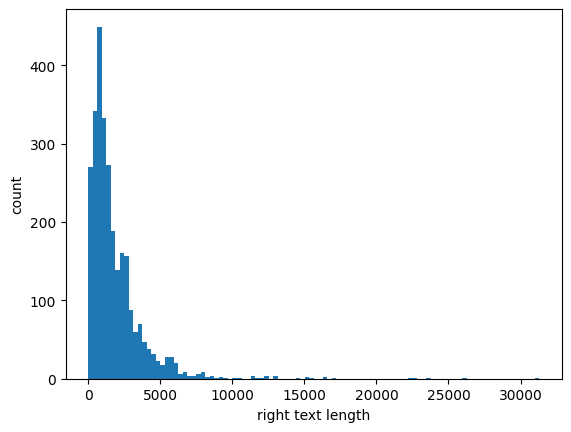

In [19]:
"""没有被删除的text文件长度分布图"""
plt.hist([len(x) for x in right_text], bins=100)
plt.xlabel('right text length')
plt.ylabel('count')
plt.show()


In [20]:
"""查看被删除的文章为虚假新闻的概率"""
del_fake_count = sum(1 for value in data['label'][dirty_id] if value == 1)
print(del_fake_count, f"{del_fake_count/del_count:.6f}")


2571 0.303721


In [21]:
"""查看未被删除的文章为虚假新闻的概率"""
right_count = sum(1 for value in data['label'][right_id] if value == 1)
print(right_count, f"{right_count/len(right_id):.6f}")

322 0.113701


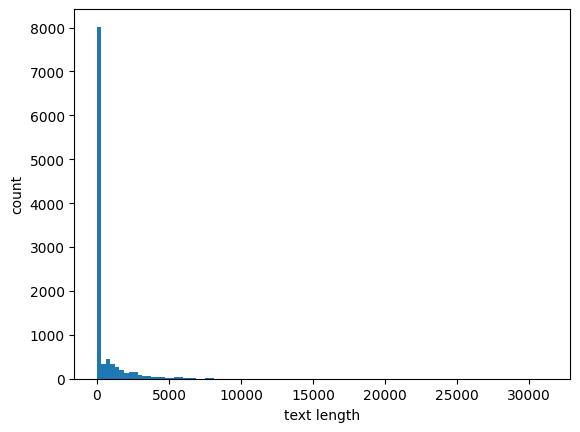

In [22]:
"""text文件长度分布图"""
plt.hist([len(x) for x in text_list], bins=100)
plt.xlabel('text length')
plt.ylabel('count')
plt.show()


In [23]:
"""text文件长度"""
text_lenths = [len(x) for x in text_list]
text_lenths_pd = pd.DataFrame(text_lenths, columns=['text_lenths'])
print("info:", text_lenths_pd.info())
print("describe:\n", text_lenths_pd.describe())
print("众数:\n", text_lenths_pd.mode())
print(text_lenths_pd.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   text_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
         text_lenths
count  10587.000000
mean     525.010673
std     1341.227423
min        0.000000
25%       20.000000
50%       52.000000
75%      196.500000
max    31288.000000
众数:
    text_lenths
0           20
text_lenths
20             4059
52              708
59              551
56              361
15              352
               ... 
2034              1
2038              1
690               1
2046              1
31288             1
Name: count, Length: 1586, dtype: int64


# 特征提取

剔除被删除的文章丢弃，得到可用于训练的数据集，也就是剩下的right_id所对应的文章rifht_text，进行特征提取。

In [24]:
for i in range(10):
    print(right_text[i])

一年后退役！韦德作出最后决定终老热火！原创柚子柚子说球有时候有些消息就是这么悄无声息在我们所有人都还沉浸在甜瓜签约正要为休赛期的这个节点松一口气联盟最后一个悬念也紧接着揭晓了韦德在今天正式宣布他的未来决定可能是正在办理离职手续应接不暇这次的重磅消息轮到了爆料“韦德将与热火队续约一年继续征战，并且在下赛季结束之后选择退役！”韦大爷的最后一个赛季！韦德的动态也基本验证了这个消息他刚刚在社交媒体上发布了照片晒出自己与热火队友们训练的合照“和兄弟们一起训练！老流氓，没有牙的，黄金手臂以及我认识的最酷的人！”而詹姆斯约翰逊的配文则是：是“我们”永远不会是“他们”！这消息来得太快柚子还没能反应我们很高兴能够看见韦德重返热火再次身披3号战袍为迈阿密打拼相信这是韦德一直以来都想要的结局留在迈阿密是他从来不曾动摇的决定我们都知道浙江队曾经开出过3年2500万美元的天价希望韦德能够选择前往中国打球虽然浙江也表示自己明白这机会很小但是就是这么一点机会他们也要试试而韦德在作出最终决定之前就委婉的拒绝了来自中国的邀请他明确地对媒体表示自己还没有决定但是如果自己选择继续征战赛场的话一定会是身披热火的战袍没有别的可能同时他也解释了自己为什么拒绝在接受迈阿密当地媒体采访时他表示“我在中国有自己的品牌，如果我去那里打球会是个非常好的决定，但是家庭因素成为了我放弃的关键原因我儿子正在上高中，我想陪伴他，我要给他所有一切可能的支持现在我要为了家庭留在迈阿密不论我是否选择退役。”韦德的回归固然是一件好事每一位他的球迷都渴望再次目睹那个3号闪电侠继续在赛场驰骋只可惜这是闪电侠的最后一个赛季了这一个赛季的打拼和较量过后我们称呼韦德的方式将不是热火队员而是“迈阿密之魂，热火名宿韦德”忆往昔峥嵘岁月单枪匹马直捣黄龙闪电侠带给我们无数的经典瞬间他将自己书写进了名人堂之中也把自己刻进了球迷们的心里当年霸气劈扣瓦莱乔如今依旧高呼“这是我的马！”我们只希望这一切都不是真的柚子只想看见这条新闻的前半段但是如果这是千真万切的结局改不了的我们只能更加珍惜韦德在的最后一个赛季！——如果你喜欢我的文章可以关注微信公众号柚子说球预览时标签不可点阅读原文微信扫一扫关注该公众号继续滑动看下一个轻触阅读原文柚子说球
著名主持人朱军被爆性骚扰实习女生！泗州文艺昨天，新浪微博百万粉丝大罗昌平发微博，内容为某匿名网友发长文控诉央视名主持朱军对自

In [25]:
right_data = data.iloc[right_id]
# 保存
with open("./train/right_data.csv", 'w', encoding='utf-8') as f:
    right_data.to_csv(f, index=False)

# 保存label为1的数据
with open("./train/right_data_fake.csv", 'w', encoding='utf-8') as f:
    right_data[right_data['label'] == 1].to_csv(f, index=False)
# 保存label为0的数据
with open("./train/right_data_real.csv", 'w', encoding='utf-8') as f:
    right_data[right_data['label'] == 0].to_csv(f, index=False)

right_data.head(10)
    

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
10,10,柚子说球,一年后退役！韦德作出最后决定终老热火！,http://mp.weixin.qq.com/s?__biz=MzIxOTI5NTk5MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/6sMnWYZVWaR85gd...,未经证实散步韦德退役谣言,0
11,11,泗县城市网,著名主持人朱军被爆性骚扰实习女生！,http://mp.weixin.qq.com/s?__biz=MzIxMzAyNzU5NQ...,http://mmbiz.qpic.cn/mmbiz_jpg/qtGJibt7gqfPS4V...,未经证实,1
16,16,女神生活街,郑恺新恋情曝光，将和他携手退出跑男？网友：迪丽热巴暗讽看真相,http://mp.weixin.qq.com/s?__biz=MzIyODUzNjk5MA...,http://mmbiz.qpic.cn/mmbiz_jpg/ayhEAOFHVILicQD...,毫无根据，言语混乱,1
17,17,房里房外,台前县吴坝镇黄河滩区迁建成果初现，街亮了，家新了，腰包鼓了，昔日穷滩区，今日新城镇，国家扶贫...,http://mp.weixin.qq.com/s?__biz=MzA4NjQ1OTY0OA...,http://mmbiz.qpic.cn/mmbiz_jpg/92LsX90lExTEwuO...,我们不是滩区，为什么拆我们的房子。老百姓越来越穷，搬不起。##这个发表文章记者认识他受贿，他...,0
18,18,海门大神,@所有海门人！海门各乡镇微信群开通了！现邀请您来一起噶闹忙咯！！！,http://mp.weixin.qq.com/s?__biz=MzU5MzA0NTQzNw...,http://mmbiz.qpic.cn/mmbiz_jpg/ZibsiaicPwOia7i...,各群都是无聊退应该取缔,0
20,20,参考消息,德媒：被中国打中“七寸” 美国农民对贸易争端失去耐心,http://mp.weixin.qq.com/s?__biz=MjM5MzA0MTg2MA...,http://mmbiz.qpic.cn/mmbiz_jpg/F1hLEK71icuAQkk...,你没有你吹牛逼那么强大,0
22,22,爱临汾,忻州中西医结合医院造假大量骗取医保资金,http://mp.weixin.qq.com/s?__biz=MzU0MTcyMjg4MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/gypEaBqfcibXQKw...,不实信息##不实信息,0
23,23,科技犬,卓伟爆料！某女星同侍父子俩，网友脑洞大开，上演名侦探柯南！,http://mp.weixin.qq.com/s?__biz=MzIwNDMyNTk0Ng...,http://mmbiz.qpic.cn/mmbiz_jpg/M4RkZsDvOoGyCJ7...,标题与内容严重不符,1
28,28,嘿星期八,别在危险的边缘试探噢,http://mp.weixin.qq.com/s?__biz=MzUzMjk0MzQyOA...,http://mmbiz.qpic.cn/mmbiz_jpg/IrQdFP8BsWUlNmV...,文中说潮州交通很乱，这点本地人不承认,0
31,31,潍坊论坛,定了！潍坊划入“青岛圈”！,http://mp.weixin.qq.com/s?__biz=MjM5MDA0MzA0Nw...,http://mmbiz.qpic.cn/mmbiz_jpg/b3GzIor9icsO0Tu...,谣言吧,0


In [26]:
"""文本长度 length"""
text_length = pd.Series([text_lenths[i] for i in right_id])
text_length
"""标题长度 title_length"""
title_length = pd.Series([len(data['Title'][i]) for i in right_id])
title_length

0       19
1       17
2       30
3       62
4       33
        ..
2827     9
2828    25
2829    30
2830    25
2831    25
Length: 2832, dtype: int64

In [27]:
"""引号、感叹号、问号引用比率 quote_symbol_rate strong_emotion_symbol_rate"""
symbol_count = []
for text in right_text:
    symbol_count.append(sum(1 for char in text if char in chinese_symbol))
symbol_count = pd.Series(symbol_count)

quote_symbol_count = []
for text in right_text:
    quote_symbol_count.append(sum(1 for char in text if char == '“' or char == '”'))
quote_symbol_count = pd.Series(quote_symbol_count)

strong_emotion_symbol_count = []
for text in right_text:
    strong_emotion_symbol_count.append(sum(1 for char in text if char == '！' or char == '？'))
strong_emotion_symbol_count = pd.Series(strong_emotion_symbol_count)

quote_symbol_rate = quote_symbol_count / symbol_count + 1e-6
strong_emotion_symbol_rate = strong_emotion_symbol_count / symbol_count + 1e-6

# 归一化
quote_symbol_rate = (quote_symbol_rate - quote_symbol_rate.min()) / (quote_symbol_rate.max() - quote_symbol_rate.min())
strong_emotion_symbol_rate = (strong_emotion_symbol_rate - strong_emotion_symbol_rate.min()) / (strong_emotion_symbol_rate.max() - strong_emotion_symbol_rate.min())

print(quote_symbol_rate.head())
print(strong_emotion_symbol_rate.head())

0    0.496296
1    0.000000
2    0.145969
3    0.000000
4    0.000000
dtype: float64
0    0.257143
1    0.086957
2    0.264706
3    0.010309
4    0.500000
dtype: float64


In [28]:
"""来源包含娱乐、八卦、搞笑"""
source_from_entertainment = []
for i in right_id:
    if "娱乐" in data['Ofiicial Account Name'][i] or "八卦" in data[
        'Ofiicial Account Name'][i] or "搞笑" in data['Ofiicial Account Name'][i]:
        source_from_entertainment.append(1)
    else:
        source_from_entertainment.append(0)
source_from_entertainment = pd.Series(source_from_entertainment)
source_from_entertainment

0       0
1       0
2       0
3       0
4       0
       ..
2827    0
2828    0
2829    0
2830    0
2831    0
Length: 2832, dtype: int64

In [29]:
"""标签包含人名"""
title_contains_person = []
for i in right_id:
    words = pseg.cut(data['Title'][i])
    count = 0
    for word, flag in words:
        if flag == 'nr':
            count += 1
    title_contains_person.append(count)

title_contains_person = pd.Series(title_contains_person)
# 归一化
title_contains_person = (title_contains_person - title_contains_person.min()) / (title_contains_person.max() - title_contains_person.min())
title_contains_person

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cxy\AppData\Local\Temp\jieba.cache
Loading model cost 0.552 seconds.
Prefix dict has been built successfully.


0       0.2
1       0.2
2       0.2
3       0.2
4       0.0
       ... 
2827    0.0
2828    0.4
2829    0.0
2830    0.0
2831    0.2
Length: 2832, dtype: float64

In [30]:
right_label_list = right_data['label'].to_list()
right_label_pd = pd.Series(right_label_list)
right_label_pd

0       0
1       1
2       1
3       0
4       0
       ..
2827    0
2828    1
2829    0
2830    0
2831    0
Length: 2832, dtype: int64

In [31]:
"""特征整合"""
my_train = pd.concat([pd.Series(right_id), text_length, title_length, quote_symbol_rate, strong_emotion_symbol_rate, 
                      source_from_entertainment, title_contains_person, right_label_pd], axis=1)
my_train.columns = ['id', 'text_length', 'title_length', 'quote_symbol_rate', 'strong_emotion_symbol_rate', 
                    'source_from_entertainment', 'title_contains_person', 'label']
my_train.head() 


,id,text_length,title_length,quote_symbol_rate,strong_emotion_symbol_rate,source_from_entertainment,title_contains_person,label
0,10,937,19,0.496296,0.257143,0,0.2,0
1,11,235,17,0.000000,0.086957,0,0.2,1
2,16,904,30,0.145969,0.264706,0,0.2,1
3,17,2204,62,0.000000,0.010309,0,0.2,0
4,18,378,33,0.000000,0.500000,0,0.0,0


In [32]:
"""保存"""
my_train.to_csv("./train/my_train.csv", index=False)